In [1]:
# All notebooks must include this
import sys
sys.path.append("../")
FIGURES_DIRECTORY="../figures/"
DATA_DIRECTORY="../data/"

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from plot_tools import set_size
from plot_tools import init_sky
# plt.style.available

In [24]:
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

def plot_example(out_dir="figures/"):
    """A simple example of creating a figure and saving as a pdf."""
    import numpy as np

    # Using seaborn's style
    # plt.style.use('seaborn')
    # With LaTex fonts
    # plt.style.use('tex')
    plt.style.use('science')
    width = 345

    x = np.linspace(0, 2 * np.pi, 100)
    # Initialise figure instance
    fig, ax = plt.subplots(1, 1, figsize=set_size(width))

    # Plot
    ax.plot(x, np.sin(x))
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\sin (\theta)$')

    # Save and remove excess whitespace
    fig.savefig(out_dir+'example_1.pdf', format='pdf', bbox_inches='tight')
    fig.savefig(out_dir+'example_1.png', format='png', bbox_inches='tight')

class ExoplanetPlotter(): 
    
    def __init__(self):
        pass

    def plot_stacked_bar(self,
                         df=None, 
                         show_values=False, 
                         value_format="{}",
                         cmap='inferno',
                         out_dir="figures/", 
                         overwrite=False,
                         use_hatch=False,
                         width=700,
                         file_format='pdf'):
        """Plots a stacked bar chart with the data and labels provided.

        Keyword arguments:
        
        show_values     -- If True then numeric value labels will 
                           be shown on each bar
        value_format    -- Format string for numeric value labels
                           (default is "{}")
     
        """
        
        # Using seaborn's style
        plt.style.use('science')
        cm = plt.cm.get_cmap(cmap)
        
        # Initialise figure instance
        fig, ax = plt.subplots(1, 1, figsize=set_size(width))
        
        # x axis labels
        start_year= 2000
        year_range=22
        category_labels = [start_year+i for i in range(year_range)]
        
        # detection methods
        methods = np.unique(df['fpl_discmethod'])
        data=np.zeros((len(methods),len(category_labels)))
      
        for i,label in enumerate(methods):
            yearly_counts = []
            for j in range(year_range):
                counts = len(df[(df.fpl_discmethod==label) & (df.fpl_disc==(start_year+j))])
                yearly_counts.append(counts)
            data[i]=yearly_counts
        
        # cumulative sum to show the evolution over the years
        data = np.cumsum(data,axis=1) 
        
        ind = list(range(year_range))
        axes = []
        cum_size = np.zeros(year_range)
        data = np.array(data)
        select_methods = ['Transit','Radial Velocity','Microlensing','Imaging']
        
        for i, row_data in enumerate(data):
            method = methods[i]
            if method not in select_methods:
                continue
            color = color = cm(i/len(methods))
            print('method %s color %s' %(method,color))
            res = ax.bar(ind, row_data, bottom=cum_size, label=methods[i], color=color)
            axes.append(res)
            cum_size += row_data

        #print(category_labels)
        import matplotlib.ticker as mticker
        # fixing xticks with FixedLocator but also using MaxNLocator to avoid cramped x-labels
        label_format = '{:d}'
        ax.xaxis.set_major_locator(mticker.MaxNLocator(year_range))
        ticks_loc = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ind))
        #ax.set_xticklabels([label_format.format(x) for x in category_labels])
        ax.set_xticklabels(category_labels)
        ax.set_xlabel('Discovery Year',fontsize=14)
        ax.set_ylabel('Total Nb. of Exoplanets',fontsize=14)
        ax.set_axisbelow(True)
        ax.grid(True)
        ax.legend()

        if show_values:
            for axis in axes:
                for bar in axis:
                    w, h = bar.get_width(), bar.get_height()
                    ax.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                             value_format.format(h), ha="center", 
                             va="center")
                    
        ax.set_title('Exoplanets Discovered (Cumulative)',fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

        plt.xticks(rotation=70)        
                
        out_file='exoplanets_by_year_stacked.'+file_format
        filename = out_dir+out_file
        
        if os.path.isfile(filename) and not overwrite:
            print('File : %s already exists , set flag overwrite True to overwrite' %filename)
        else:
            # Save and remove excess whitespace
            fig.savefig(filename, format=file_format, bbox_inches='tight')
    
    def planets_by_year(self,df=None,out_dir="figures/", width =700,out_file='exoplanets_by_year.pdf',overwrite=False,file_format='pdf'):
        """A simple example of creating a figure and saving as a pdf."""
        
        # Using seaborn's style
        plt.style.use('science')

        # load data and group planets by discovery year
        grouped_df=df.groupby(['fpl_disc']).count()['fpl_hostname']
        # grouped_df=df.groupby(['fpl_disc']).agg({'fpl_disc':'count', 'fpl_disc':'cumsum'})
        cumul_df = grouped_df.cumsum()
        
        # Initialise figure instance
        fig, ax = plt.subplots(1, 1, figsize=set_size(width))

        # Plot
        first_year=9
        ax.bar(x=grouped_df.index[first_year:],height=grouped_df[first_year:],label='Nbs. by Year',color='lightgray', edgecolor='gray',zorder=0)
        ax.plot(cumul_df[first_year:],label='Cumulative Numbers',lw=2,color='orange',zorder=0)
        #ax.axvline(x=2014,ls='--',color='red',zorder=2)
        #ax.axvline(x=2016,ls='--',color='red',zorder=2)        
        #ax.text(2012, 2000, 'Kepler DR1', bbox={'facecolor': 'lightgray','alpha': 0.5, 'pad': 10})
        #ax.text(2014, 3500, 'Kepler DR2', bbox={'facecolor': 'lightgray','alpha': 0.5, 'pad': 10})
        
        #sax.plot(grouped_df.index[first_year:],grouped_df['fpl_cumul'],label='Cumulative Numbers')
        ax.set_xlabel('Discovery Year',fontsize=14)
        ax.set_ylabel('Nb. of Exoplanets',fontsize=14)
        ax.grid(True)
        ax.legend()
        ax.set_title('Exoplanets Discovered by Year',fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

        filename = out_dir+out_file
        
        if os.path.isfile(filename) and not overwrite:
            print('File : %s already exists , set flag overwrite True to overwrite' %filename)
        else:
            # Save and remove excess whitespace
            fig.savefig(filename, format=file_format, bbox_inches='tight')
        
    def planets_by_detection_method(self, 
                                    df=None,
                                    out_dir="figures/", 
                                    width =700,
                                    out_file='exoplanets_by_discovery_method.pdf',
                                    cmap='tab20c',
                                    startangle=-60,
                                    overwrite=False):
        """A simple example of creating a figure and saving as a pdf."""
        
        # Using seaborn's style
        plt.style.use('science')

        cm = plt.cm.get_cmap(cmap)

        # Initialise figure instance
        fig, ax = plt.subplots(1, 1, figsize=set_size(width),subplot_kw=dict(aspect="equal"))

        grouped_df=df.groupby(['fpl_discmethod',]).count()['fpl_hostname'].sort_values(ascending=False)
        display(grouped_df)
        # filter a few methods 
        larger  = ['Transit','Radial Velocity','Microlensing','Imaging',]
        smaller = ['Eclipse Timing Variations','Pulsar Timing','Orbital Brightness Modulation','Pulsation Timing Variations']
        larger_df=grouped_df.loc[larger]
        larger_df = larger_df.append(pd.Series({'Others': 54}))
        #display(larger_df)
        smaller_df=grouped_df.loc[smaller]

        def func(val, allvals):
            absolute = int(round(val/100.*np.sum(allvals)))
            return "{:.1f}\{:s}".format(val,"%")

        def vals(val, total):
            perc = float(val)/float(total)*100.
            return ": {:d} \n{:.2f}\{:s}".format(val,perc,"%")

        #ax.set_prop_cycle("color", [cm(1. * i / len(grouped_df)) for i in range(len(grouped_df))])

        # Larger fractions plot
        wedges, texts  = ax.pie(
            larger_df, 
            #labels=larger_df.index,
            wedgeprops=dict(width=0.5,edgecolor='white',linewidth=3), 
            textprops=dict(fontsize=15,weight='bold'), 
            startangle=startangle,
            #autopct=lambda val: func(val, grouped_df),
            pctdistance=0.75
            )

        bbox_props = dict(boxstyle="square,pad=1.0", fc="w", ec="none", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")

        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})

            if i <3:
                text = larger_df.index[i]+ " " +vals(larger_df[i],grouped_df.sum())
                ax.annotate(text, xy=(x, y), xytext=(0.9*np.sign(x), 1.15*y),
                            horizontalalignment=horizontalalignment, **kw,size=14,weight='bold')
            else:
                text = larger_df.index[i]+ " " +vals(larger_df[i],grouped_df.sum())
                ax.annotate(text, xy=(x, y), xytext=((i/5) + 1.05*np.sign(x), i/3.15+ y),
                         horizontalalignment=horizontalalignment, **kw,size=14,weight='bold')

            #ax.legend()    

        filename = out_dir+out_file
        
        if os.path.isfile(filename) and not overwrite:
            print('File : %s already exists , set flag overwrite True to overwrite' %filename)
        else:
            # Save and remove excess whitespace
            fig.savefig(filename, format='pdf', bbox_inches='tight')

    def planets_by_position(self,df=None,out_dir="figures/", width =700,cmap='tab20c',overwrite=False,file_format='pdf'):
        """A simple example of creating a figure and saving as a pdf."""
        
        # Using seaborn's style
        plt.style.use('science')

        # get the ra/dec positions of exoplanets from df
        ra = coord.Angle(df['ra'].astype(float)*u.degree)
        ra = ra.wrap_at(180*u.degree)
        dec = coord.Angle(df['dec'].astype(float)*u.degree)
        
        #  encode the different techniques to numeric
        encoder = LabelEncoder()
        df['encoded_discmethod'] = encoder.fit_transform(df['fpl_discmethod'])
        
        # initialize an all sky plot and plot the exoplanet positions on top
        fig , ax = init_sky(galactic_plane_color=None,ecliptic_plane_color=None,projection='aitoff',ra_center=180)
       
        # initialize color map
        cm = plt.cm.get_cmap(cmap)
        
        #labels1=list(np.unique(df['fpl_discmethod'])[:max_labels])
        max_labels=5
        my_labels=['Transit','Radial Velocity','Microlensing','Imaging',
                   'Transit Timing Variations','Eclipse Timing Variations',
                   'Pulsar Timing','Orbital Brightness Modulation',
                   'Pulsation Timing Variations','Disk Kinematics','Astrometry'][:max_labels]
        
        # # display exoplanets by ra/dec position , color encode positiosn by detection method
        colors = df['encoded_discmethod']
        sc = ax.scatter(ra.radian, dec.radian,marker='.', s=15, label=my_labels, c=colors,cmap=cm)
    
        # create the mapping between method and colors as extraccted from the plot
        label_colors={}
        for i in range(len(ra.radian)):
            method = df['fpl_discmethod'][i]
            color = sc.to_rgba(colors[i])
            if method not in label_colors:
                label_colors[method]=color
        
        # customize legend to match seleted colormap colors
        custom_lines = []
        for label in my_labels:
            color = label_colors[label]
            custom_lines.append(Line2D([0], [0],c=color,lw=2))
            
        # Put a legend below current axis : shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(custom_lines, my_labels,loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=len(my_labels),fontsize=12)
        ax.set_title('Exoplanets Distribution in Sky',fontsize=14,loc='right')

        out_file='exoplanets_by_position.'+file_format
        filename = out_dir+out_file
        
        if os.path.isfile(filename) and not overwrite:
            print('File : %s already exists , set flag overwrite True to overwrite' %filename)
        else:
            # Save and remove excess whitespace
            fig.savefig(filename, format=file_format, bbox_inches='tight')
            
            
    def planets_by_size(self,df=None,out_dir="figures/", width =700,out_file='exoplanets_by_size.pdf',cmap='tab20c',overwrite=False,det_method='Transit'):
        """A simple example of creating a figure and saving as a pdf."""
        # Using seaborn's style
        plt.style.use('science')
        
        # filter by specified detection method
        # df= df.loc[df.fpl_discmethod == method]

        # get the planets sizes (in Earth Radii)
        sizes = df['fpl_rade']
        sizes_err = df['fpl_radeerr1']

        # get the planets masses (in Earth Masses)
        masses = df['fpl_bmasse']
        masses_err = df['fpl_bmasseerr1']

        # initialize an all sky plot and plot the exoplanet positions on top
        fig , ax = plt.subplots(1,1,figsize=set_size(width))

        # initialize color map
        cm = plt.cm.get_cmap(cmap)

        encoder = LabelEncoder()
        df['encoded_discmethod'] = encoder.fit_transform(df['fpl_discmethod'])

        colors = df['encoded_discmethod']

        # logarithmic plot by sizes 
        # ax.scatter(masses, sizes, c=colors, s=sizes, alpha=0.5,cmap=cmap)
        # plt.colorbar(ax=ax);  # show color scale
        # ax.set_title('Sizes of Exoplanets',fontsize=14)
        # ax.set_xlabel('Exoplanet Mass (x Earth Mass)',fontsize=14)
        # ax.set_ylabel('Exoplanet Size (x Earth Radius)',fontsize=14)
        # ax.set_xlim([0,50000])
        # ax.set_ylim([0,40])
        # ax.set_yscale('log')
        # ax.set_xscale('log')


        # Radii range and count by range
        types=['Earth Like','Super Earths','Neptunes','Jupyters','Sub-stellar']
        ranges = [0, 1.25, 2, 6, 10,100]
        counts_by_range = df.fpl_rade.value_counts(bins=ranges, sort=False) 
        
        # Prepare legend
        custom_lines = []
        colors = []
        for i,label in enumerate(types):
            color = cm(i*2/len(types))
            if i ==3 :
                color = (1.0, 0.80, 0.15, 1.0)
            colors.append(color)
            custom_lines.append(Line2D([0], [0],c=color,lw=2))
            
        # PLot bar like
        counts_by_range.plot.bar(rot=0,ax=ax,color=colors, edgecolor='gray')
        ax.set_xlabel('Exoplanet Size (x Earth Radius)',fontsize=14)
        ax.set_ylabel('Nb. of Exoplanets',fontsize=14)
        ax.set_title('Exoplanet Types',fontsize=14)
        ax.legend(custom_lines, types,loc='upper right',bbox_to_anchor=(0.85, 1),fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
        
        # from mpl_toolkits.axes_grid1 import make_axes_locatable
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes("right", size="5%", pad=0.05)
        # plt.colorbar(cax=cax)
        
        filename = out_dir+out_file
        
        if os.path.isfile(filename) and not overwrite:
            print('File : %s already exists , set flag overwrite True to overwrite' %filename)
        else:
            # Save and remove excess whitespace
            fig.savefig(filename, format='pdf', bbox_inches='tight')
            
            
    def planets_to_host_star(self,df=None,out_dir="figures/", width =700,out_file='exoplanets_to_host.pdf',cmap='tab20c',overwrite=False,bbox_to_anchor=(1.04,1)):
        """Shows exoplanet mass relative to that of host star, detection method influence"""
        # Using seaborn's style
        plt.style.use('science')
       
        # filter our data from negligleable counts
        select_methods = ['Transit','Radial Velocity','Microlensing','Imaging']
        
        df = df[df.fpl_discmethod.isin(select_methods)]
        
        # get the planets sizes (in Earth Radii)
        sizes = df['fpl_rade']
        sizes_err = df['fpl_radeerr1']

        # get the planets masses (in Earth Masses)
        masses = df['fpl_bmasse']
        masses_err = df['fpl_bmasseerr1']
        
        # get the host star masses (in Sun Masses)
        host_masses = df['fst_mass']
        host_masses_err = df['fst_masserr1']
        
        # get the Semi-mjor axis (AU) of the exoplanets orbit
        smajor_axis = df['fpl_smax']
        smajor_axis_err = df['fpl_smaxerr1']
        
        # initialize plot
        fig , ax = plt.subplots(1,1,figsize=(6,8))

        # initialize color map
        cm = plt.cm.get_cmap(cmap)

        # select point colors by detection method from specified color map
        # to match the distribution per year colors
        colors = {
            'Imaging': (0.9222606689734717, 0.5674740484429065, 0.4486735870818915, 1.0),
            'Microlensing':(0.9797001153402538, 0.7840830449826989, 0.6848904267589389, 1.0),
            'Radial Velocity':(0.4814302191464823, 0.7148788927335642, 0.839446366782007, 1.0),
            'Transit':(0.2366013071895425, 0.5418685121107266, 0.7470203767781622, 1.0)
        }
            
        custom_lines=[]
        for i,label in enumerate(select_methods):
            color=colors[label]
            custom_lines.append(Line2D([0], [0],c=color,lw=2))
            
        # LEFT : logarithmic plot of exoplanet mass vs host star mass, color coded by detection method
        #grouped = df.groupby('fpl_discmethod')
        #for key, group in grouped:
        #    group.plot(ax=axs[0], kind='scatter', x=masses, y=host_masses, label=key, color=colors[key])
        ax.scatter(masses, smajor_axis, marker='.',c=df['fpl_discmethod'].map(colors),cmap=cmap)
        ax.set_title('Sizes of Exoplanets',fontsize=16)
        ax.set_xlabel('Exoplanet Mass [$M_{J}$]',fontsize=16,weight='bold')
        ax.set_ylabel('Distace to Star [AU]',fontsize=16,weight='bold')
        ax.set_yscale('log')
        ax.set_xscale('log')
        select_methods = ['Transit Photometry','Radial Velocity','Microlensing','Imaging']
        ax.legend(custom_lines, select_methods,loc='upper right',fontsize=14,bbox_to_anchor=bbox_to_anchor)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        # RIGHT : logarithmic plot of exoplanet mass vs host star mass, color coded by detection method
        #grouped = df.groupby('fpl_discmethod')
        #for key, group in grouped:
        #    group.plot(ax=axs[0], kind='scatter', x=smajor_axis, y=host_masses, label=key, color=colors[key])
        # axs[1].scatter(smajor_axis, host_masses, marker='.',c=df['fpl_discmethod'].map(colors),cmap=cmap)
        # axs[1].set_title('Orbits of Exoplanets',fontsize=14)
        # axs[1].set_xlabel('Semi-Major Axis [AU]',fontsize=12,weight='bold')
        # axs[1].set_ylabel('Host Star Mass [$M_{\odot}$]',fontsize=12,weight='bold')
        # axs[1].set_yscale('log')
        # axs[1].set_xscale('log')
        # axs[1].set_ylim([0,100])
        # axs[1].legend(custom_lines, methods,loc='upper right',fontsize=10,bbox_to_anchor=bbox_to_anchor)
        
        filename = out_dir+out_file
        
        if os.path.isfile(filename) and not overwrite:
            print('File : %s already exists , set flag overwrite True to overwrite' %filename)
        else:
            # Save and remove excess whitespace
            fig.savefig(filename, format='pdf', bbox_inches='tight')

In [25]:
# Load the dataset
df = pd.read_csv(DATA_DIRECTORY+'compositepars.csv',header=109)
df.head()
# Create a plotter instance 
plotter = ExoplanetPlotter()

### Exoplanets by Year

method Imaging color (0.9222606689734717, 0.5674740484429065, 0.4486735870818915, 1.0)
method Microlensing color (0.9797001153402538, 0.7840830449826989, 0.6848904267589389, 1.0)
method Radial Velocity color (0.4814302191464823, 0.7148788927335642, 0.839446366782007, 1.0)
method Transit color (0.2366013071895425, 0.5418685121107266, 0.7470203767781622, 1.0)


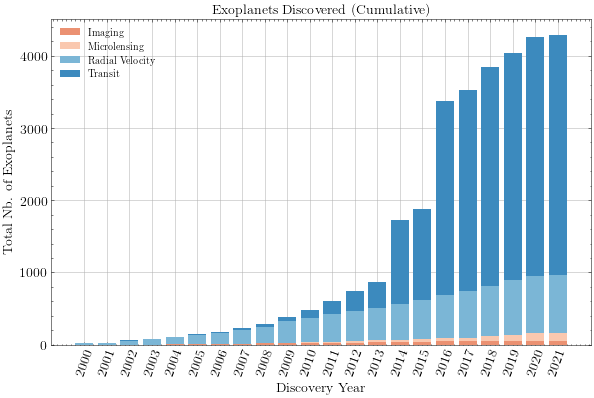

In [19]:
plotter.plot_stacked_bar(df=df,out_dir=FIGURES_DIRECTORY,cmap='RdBu',overwrite=True,file_format='png')

File : ../figures/exoplanets_by_year.pdf already exists , set flag overwrite True to overwrite


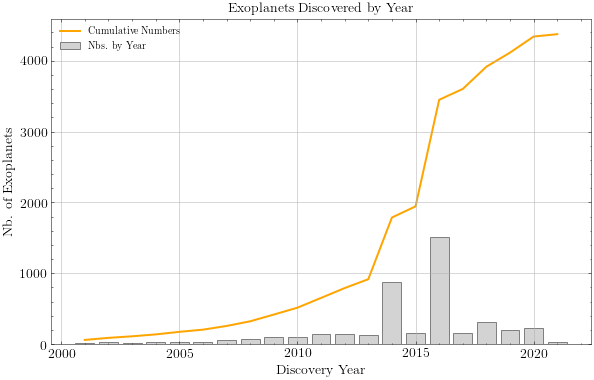

In [12]:
# show discoveries by year 
plotter.planets_by_year(df=df,out_dir=FIGURES_DIRECTORY)

### Exoplanets by Detection Method

fpl_discmethod
Transit                          3325
Radial Velocity                   837
Microlensing                      108
Imaging                            51
Transit Timing Variations          21
Eclipse Timing Variations          16
Pulsar Timing                       7
Orbital Brightness Modulation       6
Pulsation Timing Variations         2
Disk Kinematics                     1
Astrometry                          1
Name: fpl_hostname, dtype: int64

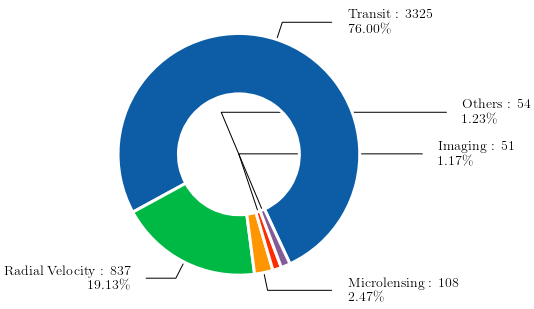

In [13]:
# show discoveries by detection method 
plotter.planets_by_detection_method(df=df,out_dir=FIGURES_DIRECTORY,width=650,cmap='Paired',startangle=-65,overwrite=True)

### Exoplanets by Position

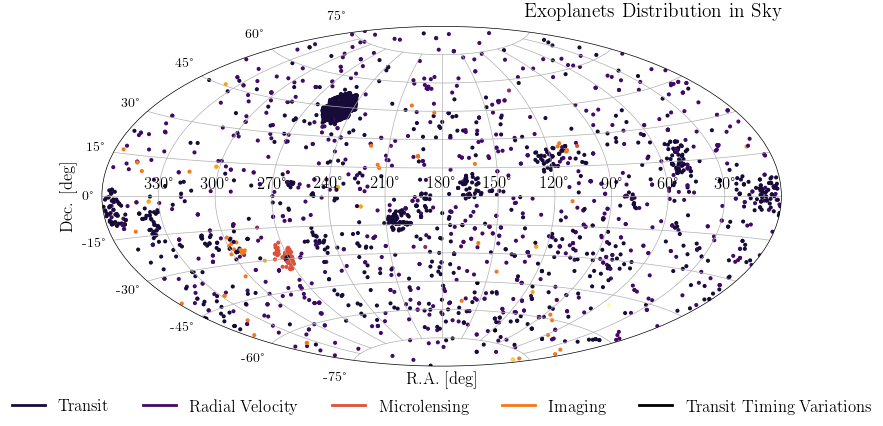

In [26]:
# show discoveries by position in the sky 
plotter.planets_by_position(df=df,out_dir=FIGURES_DIRECTORY,cmap='inferno_r',overwrite=True,file_format='png')

### Exoplanets by Size

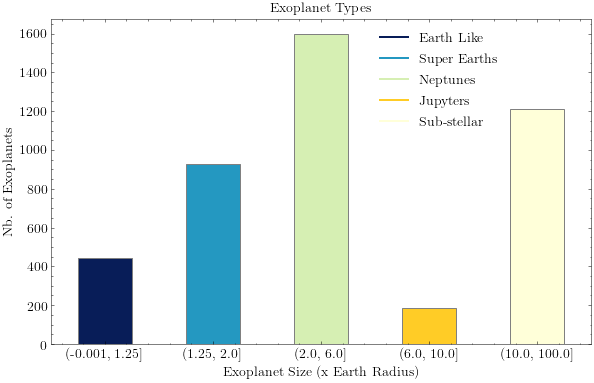

In [9]:
plotter.planets_by_size(df=df,out_dir=FIGURES_DIRECTORY,overwrite=True,cmap='YlGnBu_r')

### Exoplanet to Host

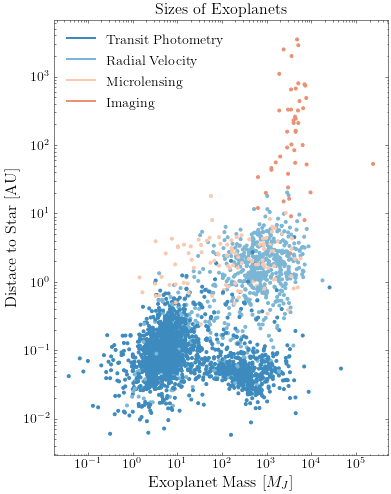

In [10]:
plotter.planets_to_host_star(df=df,out_dir=FIGURES_DIRECTORY,overwrite=True,width =700,bbox_to_anchor=(0.55,1),cmap='jet')